# Определение перспективного тарифа для телеком компании
## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание данных

### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана
### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты - будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [122]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st

import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
users = pd.read_csv('./datasets/users.csv')
calls = pd.read_csv('./datasets/calls.csv')
messages = pd.read_csv('./datasets/messages.csv')
internet = pd.read_csv('./datasets/internet.csv')
tariffs = pd.read_csv('./datasets/tariffs.csv')

## Шаг 1. Изучение общей информации

### Users

In [124]:
users.info()
# users.set_index('user_id', inplace=True)
users.info()
print()
print(users.describe())
print()
users.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
28,1028,20,NaN,Тверь,Рустем,Евсеев,2018-10-02,ultra
429,1429,54,NaN,Санкт-Петербург,Джулия,Белякова,2018-01-26,smart
328,1328,44,NaN,Мурманск,Рауль,Аркадьев,2018-10-16,ultra
37,1037,73,NaN,Череповец,Изольда,Архипова,2018-10-13,smart
250,1250,20,NaN,Смоленск,Лия,Ракова,2018-04-11,smart
494,1494,62,NaN,Омск,Ренат,Андропов,2018-08-17,smart
187,1187,60,NaN,Рязань,Виталий,Овчинников,2018-08-22,smart
118,1118,65,NaN,Казань,Вера,Латышева,2018-03-06,smart
208,1208,69,NaN,Пермь,Ева,Сахарова,2018-03-24,ultra
444,1444,35,NaN,Нижний Новгород,Иулиан,Воронин,2018-11-07,smart


### Calls

In [125]:
calls.info()
print()
print(calls.describe())
print()
calls.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000



,id,call_date,duration,user_id
132775,1341_5,2018-08-17,0.00,1341
54299,1135_592,2018-08-19,15.02,1135
7190,1019_132,2018-09-15,13.21,1019
185573,1458_865,2018-08-29,0.00,1458
165867,1409_492,2018-12-27,6.26,1409
152621,1380_256,2018-08-17,6.17,1380
86165,1217_30,2018-03-09,2.28,1217
143331,1363_243,2018-09-04,16.42,1363
137990,1352_714,2018-09-15,8.53,1352
185839,1458_1131,2018-05-12,0.00,1458


### Messages

In [126]:
messages.info()
print()
print(messages.describe())
print()
messages.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000



,id,message_date,user_id
40570,1173_6,2018-08-17,1173
37651,1165_5,2018-12-15,1165
5623,1021_779,2018-05-09,1021
80893,1338_91,2018-09-20,1338
118471,1482_33,2018-07-30,1482
72480,1307_124,2018-07-04,1307
113922,1464_56,2018-05-06,1464
24601,1102_28,2018-10-09,1102
106468,1431_210,2018-06-15,1431
44436,1193_192,2018-01-18,1193


### Internet

In [127]:
internet.info()
print()
print(internet.describe())
print()
internet.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000



,Unnamed: 0,id,mb_used,session_date,user_id
64039,64039,1218_167,133.28,2018-10-02,1218
38533,38533,1135_13,2.89,2018-10-13,1135
134195,134195,1450_78,297.99,2018-11-01,1450
83712,83712,1284_66,338.78,2018-07-27,1284
103930,103930,1352_154,765.40,2018-06-20,1352
2671,2671,1009_313,215.57,2018-10-13,1009
66893,66893,1227_490,72.24,2018-12-01,1227
3697,3697,1011_564,341.04,2018-05-17,1011
57969,57969,1195_52,0.00,2018-12-28,1195
50971,50971,1174_179,336.50,2018-06-27,1174


### Tarifs

In [128]:
tariffs.info()
print()
print(tariffs.describe())
print()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes

       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.000000        500

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Шаг 2. Подготовка данных

**При изучении данных можно обнаружить в dataframe internet столбец без имени, судя по его значениям это столбец с индексаами, поэтому мы его переименовываем в index и назначаем его индексом для dataframe**

In [129]:
internet.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
internet.set_index('index', inplace=True)
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


**Переводим даты из строки в тип datetime**

In [130]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [131]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [132]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [133]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


**Округляем минуты и гигабайты**

In [134]:
calls['duration'] = calls['duration'].apply(np.ceil)
print(calls.sample(20))
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
print(internet.sample(20))

id  call_date  duration  user_id
106156   1274_152 2018-07-26      14.0     1274
149156     1377_3 2018-05-07       4.0     1377
110194  1282_1088 2018-08-25       4.0     1282
120615   1311_150 2018-08-29       0.0     1311
79091     1197_83 2018-07-30       5.0     1197
183719   1456_191 2018-12-23      12.0     1456
82860      1207_7 2018-08-15      15.0     1207
48685    1121_342 2018-10-27       9.0     1121
178789    1446_74 2018-12-21      12.0     1446
158977   1393_229 2018-05-15       5.0     1393
111502   1285_430 2018-06-27       0.0     1285
190714   1469_333 2018-07-28       4.0     1469
176065    1434_64 2018-12-29       0.0     1434
7158     1019_100 2018-07-25       7.0     1019
115270    1296_83 2018-08-16       0.0     1296
28738     1072_64 2018-11-08      20.0     1072
30326    1076_618 2018-04-26      12.0     1076
58788    1148_251 2018-04-22       5.0     1148
136264    1347_76 2018-11-10       4.0     1347
15081     1040_80 2018-08-10       8.0     1040
       

**Нужно ли убрать звонки с 0 продолжительностью?**

duration        user_id
count  202607.000000  202607.000000
mean        7.158198    1253.940619
std         5.959173     144.722751
min         0.000000    1000.000000
25%         2.000000    1126.000000
50%         6.000000    1260.000000
75%        11.000000    1379.000000
max        38.000000    1499.000000


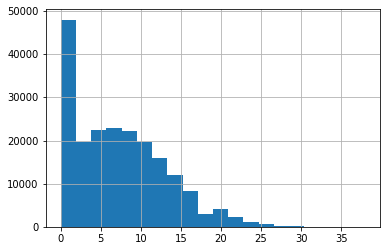


            duration        user_id
count  162994.000000  162994.000000
mean        8.897880    1254.149877
std         5.353761     144.751050
min         1.000000    1000.000000
25%         5.000000    1126.000000
50%         8.000000    1261.000000
75%        12.000000    1379.000000
max        38.000000    1499.000000


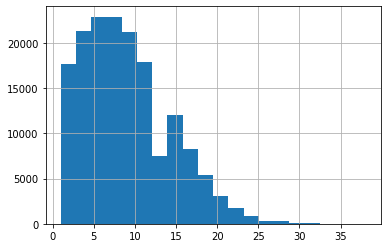

In [135]:
print(calls.describe())
calls['duration'].hist(bins=20)
plt.show()
print()
print(calls[calls['duration'] > 0].describe())
calls[calls['duration'] > 0]['duration'].hist(bins=20)
plt.show()

calls = calls[calls['duration'] > 0]

Как видно из графиков, звонков с продолжительностью 0 очень много, но эти записи портят характеристики, а именно среднее и медиану, т.к. для дальнейшего анализа эти данные не нужны, то лучше их отбросить.

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [136]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_by_months = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_by_months.columns = ['calls_count', 'minutes_used']
calls_by_months.head(15)

calls_count  minutes_used
user_id month                           
1000    5               17         159.0
        6               28         172.0
        7               41         340.0
        8               42         408.0
        9               46         466.0
        10              44         350.0
        11              37         338.0
        12              38         333.0
1001    11              45         430.0
        12              47         414.0
1002    6               14         117.0
        7               21         214.0
        8               37         289.0
        9               25         206.0
        10              24         212.0

### Количество отправленных сообщений по месяцам

In [137]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_by_months = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_by_months.columns = ['messages_used']
messages_by_months.head(15)

messages_used
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
        10                73
        11                58
        12                70
1002    6                  4
        7                 11
        8                 13
        9                  4
        10                10
        11                16
        12                12

### Объем израсходованного интернет-трафика по месяцам

In [138]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_by_months = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_by_months.columns = ['mbs_used']
internet_by_months['gbs_used'] = internet_by_months['mbs_used'] / 1024
# internet_by_months['gbs_used'] = internet['mb_used'].apply(np.ceil)
internet_by_months.head(15)

mbs_used   gbs_used
user_id month                     
1000    5        2256.0   2.203125
        6       23257.0  22.711914
        7       14016.0  13.687500
        8       14070.0  13.740234
        9       14581.0  14.239258
        10      14717.0  14.372070
        11      14768.0  14.421875
        12       9827.0   9.596680
1001    11      18452.0  18.019531
        12      14053.0  13.723633
1002    6       10871.0  10.616211
        7       17601.0  17.188477
        8       20347.0  19.870117
        9       16712.0  16.320312
        10      13905.0  13.579102

**Объединяем данные в единный dataframe для дальнейшего анализа** 

In [139]:
usage = calls_by_months.join(messages_by_months, how='outer')
usage = usage.join(internet_by_months, how='outer')
usage.fillna({'calls_count': 0, 'minutes_used': 0, 'messages_used': 0, 'mbs_used': 0}, inplace=True)

usage.reset_index(level='month', inplace=True)

users_usage = users.merge(usage, on='user_id')
users_usage.info()
users_usage.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        3214 non-null   int64         
 1   age            3214 non-null   int64         
 2   churn_date     187 non-null    datetime64[ns]
 3   city           3214 non-null   object        
 4   first_name     3214 non-null   object        
 5   last_name      3214 non-null   object        
 6   reg_date       3214 non-null   datetime64[ns]
 7   tariff         3214 non-null   object        
 8   month          3214 non-null   int64         
 9   calls_count    3214 non-null   float64       
 10  minutes_used   3214 non-null   float64       
 11  messages_used  3214 non-null   float64       
 12  mbs_used       3214 non-null   float64       
 13  gbs_used       3203 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(3), object(4)
memory usage: 376.

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,minutes_used,messages_used,mbs_used,gbs_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,17.0,159.0,22.0,2256.0,2.203125
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,28.0,172.0,60.0,23257.0,22.711914
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,41.0,340.0,75.0,14016.0,13.687500
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,42.0,408.0,81.0,14070.0,13.740234
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,46.0,466.0,57.0,14581.0,14.239258
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10,44.0,350.0,73.0,14717.0,14.372070
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11,37.0,338.0,58.0,14768.0,14.421875
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12,38.0,333.0,70.0,9827.0,9.596680
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,45.0,430.0,0.0,18452.0,18.019531
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12,47.0,414.0,0.0,14053.0,13.723633


**Рассчёт помесячной выручки**

In [140]:
def monthly_revenue(row):
    tariff = row['tariff']

    tariff_data = tariffs[tariffs['tariff_name'] == tariff].iloc[0]
    total = tariff_data['rub_monthly_fee']

    minutes_over_tariff = row['minutes_used'] - tariff_data['minutes_included']
    if minutes_over_tariff > 0:
        total += minutes_over_tariff * tariff_data['rub_per_minute']
    
    messages_over_tariff = row['messages_used'] - tariff_data['messages_included']
    if messages_over_tariff > 0:
        total += messages_over_tariff * tariff_data['rub_per_message']

    internet_over_tariff = row['mbs_used'] - tariff_data['mb_per_month_included']
    if internet_over_tariff > 0:
        total += np.ceil(internet_over_tariff / 1024) * tariff_data['rub_per_gb']

    return total

users_usage['monthly_revenue'] = users_usage.apply(monthly_revenue, axis=1)

In [141]:
users_usage.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,minutes_used,messages_used,mbs_used,gbs_used,monthly_revenue
1375,1216,74,NaT,Волгоград,Рустам,Малинин,2018-11-23,smart,11,36.0,348.0,18.0,5059.0,4.940430,550.0
3152,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,11,0.0,0.0,20.0,17516.0,17.105469,1150.0
634,1100,58,NaT,Санкт-Петербург,Руслан,Красильников,2018-07-02,smart,7,67.0,529.0,53.0,17756.0,17.339844,1246.0
3105,1481,70,NaT,Москва,Клавдия,Чижова,2018-02-26,smart,5,45.0,460.0,18.0,18073.0,17.649414,1150.0
2292,1363,69,NaT,Нижний Тагил,Оксана,Болдырева,2018-03-04,ultra,4,80.0,629.0,0.0,14361.0,14.024414,1950.0
706,1110,26,NaT,Петрозаводск,Матвей,Александрович,2018-05-06,smart,12,46.0,390.0,42.0,18161.0,17.735352,1150.0
2822,1436,75,NaT,Москва,Радим,Ерофеев,2018-04-04,ultra,11,56.0,479.0,20.0,15753.0,15.383789,1950.0
1137,1177,75,NaT,Новосибирск,Лолита,Аничкина,2018-06-19,smart,11,42.0,341.0,0.0,15395.0,15.034180,750.0
832,1130,58,NaT,Тюмень,Инара,Крюкова,2018-04-01,smart,8,55.0,499.0,60.0,16965.0,16.567383,980.0
1891,1298,29,NaT,Новосибирск,Надежда,Чеснокова,2018-07-26,smart,11,52.0,469.0,38.0,19843.0,19.377930,1550.0


###

## Шаг 3. Анализ данных

In [142]:
users_usage_grouped_by_tariff = users_usage.pivot_table(index='tariff', values=['minutes_used', 'messages_used', 'gbs_used'], aggfunc={'mean', 'var', 'std'}).round(2)
users_usage_grouped_by_tariff

gbs_used              messages_used                 minutes_used  \
           mean   std    var          mean    std      var         mean   
tariff                                                                    
smart     15.86  5.73  32.85         33.38  28.23   796.81       417.93   
ultra     19.23  9.72  94.46         49.36  47.80  2285.27       526.62   

                           
           std        var  
tariff                     
smart   190.31   36219.32  
ultra   317.61  100873.63

In [143]:
smart_users = users_usage[users_usage['tariff'] == 'smart']
ultra_users = users_usage[users_usage['tariff'] == 'ultra']

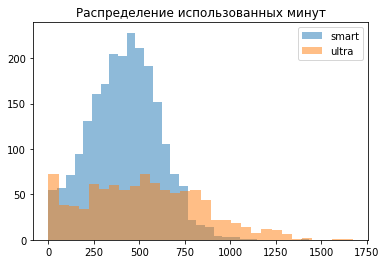

In [144]:
fig, ax = plt.subplots()
ax.hist(smart_users['minutes_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['minutes_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных минут')
plt.legend()
plt.show()

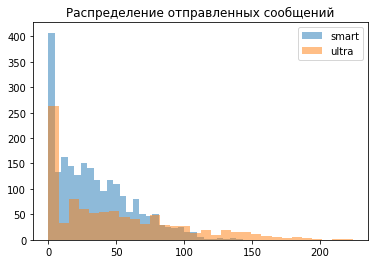

In [145]:
fig, ax = plt.subplots()
ax.hist(smart_users['messages_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['messages_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение отправленных сообщений')
plt.legend()
plt.show()

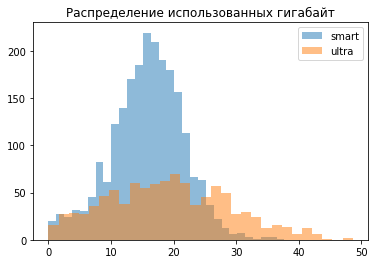

In [146]:
fig, ax = plt.subplots()
ax.hist(smart_users['gbs_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['gbs_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных гигабайт')
plt.legend()
plt.show()

In [156]:
monthly_revenue_by_tariff = users_usage.pivot_table(index='tariff', values='monthly_revenue', aggfunc=['sum', 'mean'])
monthly_revenue_by_tariff

,sum,mean
,monthly_revenue,monthly_revenue
tariff,,
smart,2885751.0,1294.63930
ultra,2040000.0,2071.06599


**Выводы:** судя по гистограммам и сводной таблице 99% пользователей тарифа ультра не выходят за пределы включенных в тариф минут и сообщений, в отличии от пользователей тарифа смарт. А использование интернета в обоих тарифах часто выходит за пределы тарифа, в случае тарифа смарт этот показатель больше.

## Шаг 4. Проверка гипотез

In [ ]:
alpha = .05

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

H0 - средняя выручка пользователей тарифов равна

H1 - средняя выручка тарифов пользователей различается

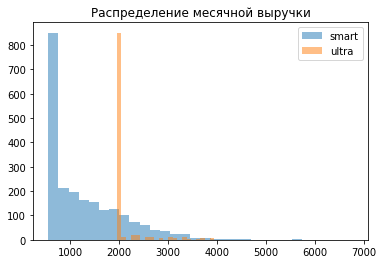

In [150]:
fig, ax = plt.subplots()
ax.hist(smart_users['monthly_revenue'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['monthly_revenue'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение месячной выручки')
plt.legend()
plt.show()

Так как у нас две независимых выборки с диксретными величинами, распределение которых стремятся к нормальному, для проверки гипотезы мы используем критерий стъюдента.

In [148]:
mean_revenue_by_tariff_test = st.ttest_ind(
    smart_users['monthly_revenue'], 
    ultra_users['monthly_revenue'])

print('p-значение:', mean_revenue_by_tariff_test.pvalue)

if (mean_revenue_by_tariff_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


**Вывод:** p-value показывает нам, что нет оснований принять нулевую гипотезу. 

**Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

H0 - средняя выручка пользователей тарифов из Москвы и не из Москвы равна

H1 - средняя выручка пользователей тарифов из Москвы и не из Москвы различается

In [ ]:
moscow_users = users_usage[users_usage['city'] == 'Москва']
not_moscow_users = users_usage[~(users_usage['city'] == 'Москва')]

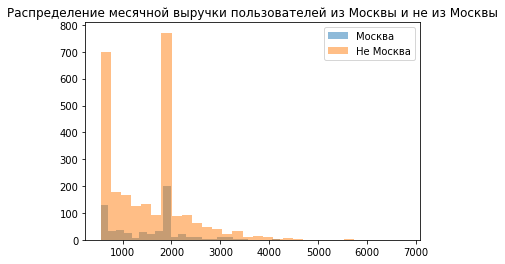

In [153]:
fig, ax = plt.subplots()
ax.hist(moscow_users['monthly_revenue'], bins=30, alpha=0.5, label='Москва')
ax.hist(not_moscow_users['monthly_revenue'], bins=30, alpha=0.5, label='Не Москва')
ax.set_title('Распределение месячной выручки пользователей из Москвы и не из Москвы')
plt.legend()
plt.show()

Так как у нас две независимых выборки с диксретными величинами, распределение которых стремятся к нормальному, для проверки гипотезы мы также используем критерий стъюдента.

In [149]:
mean_revenue_from_moscow_by_tariff_test = st.ttest_ind(
    moscow_users['monthly_revenue'], 
    not_moscow_users['monthly_revenue'])

print('p-значение:', mean_revenue_by_tariff_test.pvalue)

if (mean_revenue_by_tariff_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


**Вывод:** p-value показывает нам, что нет оснований отвергнуть нулевую гипотезу. 

## Шаг 5. Общий вывод

In [ ]:
Проведя анализ данных и проверив гипотезы мы можем сделать вывод что тариф смарт принесет компании мегалайн больше прибыли, так как это более доступный тариф, его выбирают гораздо больше пользователей и эти пользователи чаще выходят за пределы тарифа, что приносит дополнительную прибыль, хоть и среднее значение прибыли у этого тарифа ниже, чем у тарифа ультра. Пользователи обоих тарифов чаще берут дополнительные гигабайты интернета, чем остальных услуг, а пользователи тарифа смарт ещё часто посылают сообщения, выйдя за пределы тарифа. Так же мы не смогли подтвердить гипотезу что, средняя выручка зависит от того в Москве находятся пользователи или нет.